In [78]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import numpy as np
!pip install scikit-learn
from sklearn.impute import KNNImputer
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



pd.set_option('display.float_format', '{:.2f}'.format) #Evitar notación científica

# MLY0100: Evaluación Parcial Nº2
* CARLA FRANCISCA SEPULVEDA MEYNARD
* MADELAINE STEPHANIE ESCOBAR DURAN
* ADOLFO ANDRES MAZA PENA
22/10/2024

# 1. Comprensión del negocio

En este trabajo se realizó un análisis de datos de clientes de la compañía utilizando herramientas que emplean Python, como Jupyter Notebook y Google Colab. El objetivo fue explorar las variables, transformarlas, ver sus relaciones y generar modelos de clasificación. Este trabajo se ajusta a una secuencia en base a la metodología CRISP-DM. Se implementaron varios modelos, incluyendo regresión logística, SVM, KNN y árboles de decisión, evaluando su desempeño a través de métricas como la precisión, el recall y el área bajo la curva (AUC). La validación cruzada se empleó para asegurar la robustez de los resultados, permitiendo una comparación justa entre los diferentes enfoques de modelado, con el fin de entregar soluciones de datos ante la aparición de nueva información dentro de la empresa.

**Es importante señalar que no se usará un modelo de regresión lineal o multilineal en este proceso, pues la variable 'target' es de naturaleza binaria**. Ese tipo de modelos son empleados para variables objetivo de tipo continuo, por lo que no funcionarían para la tarea a emprender. Además, según los requerimientos de la empresa, lo solicitado es generar algoritmos de aprendizaje según modelos de clasificación, por lo que la regresión típica no es requerida para este caso. Por último, se debe recordar que la regresión logística no es propiamente una regresión en cuanto tal, porque su función es para modelar la probabilidad de las observaciones en su pertenencia a una clase de la variable objetivo. 

# 2. Comprensión de datos


## 2.1 Recolección de datos

In [3]:
# Acceso a documentos en drive

#from google.colab import drive
#drive.mount('/content/drive')

In [79]:
# Carga de documento excel

try:
    archivo_excel = "Base_clientes_Monopoly.xlsx"  # Cambia esto por el nombre correcto
    df = pd.read_excel(archivo_excel, sheet_name=0, nrows=10000, skiprows=1) ## Selección de 10000 casos de la primera hoja con columnas elegidas y omisión de primera fila
    print("Archivo cargado exitosamente")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

Archivo cargado exitosamente


Para la selección correcta de los features de los modelos a desarrollar, la primera decisión fue realizar una serie de correlaciones entre posibles características continuas y la variable 'target' binaria. En una iteración previa, se utilizó variables nominales como Sexo y Región. Estas también serán revisadas en esta primera fase de comprensión de los datos, más cuando puede afirmarse que existe relación entre Sexo y Region con 'target'. Se empleo la prueba de chi-cuadrado para esta labor.

In [80]:
# Asegúrate de que esta es la variable objetivo
target2 = df['target']

correlaciones = {}

variables_continuas = [
    'CUPO_L1', 'CUPO_MX', 'CUPO_L2', 'Col_T12', 'ColL1TE_T12',
    'EeccInt_T12', 'EeccNac_T12', 'Fac_T12', 'FacAI_T12',
    'FacAN_T12', 'FacCCOT_T12', 'FacCCPC_T12', 'FacCI_T12',
    'FacCN_T12', 'FacCOL_T12', 'FacDebAtm_T12', 'FacDebCom_T12',
    'FacPAT_T12', 'FlgAct_T12', 'FlgActAI_T12', 'FlgActAN_T12',
    'FlgActCCOT_T12', 'FlgActCCPC_T12', 'FlgActCI_T12',
    'FlgActCN_T12', 'FlgActCOL_T12', 'FlgActPAT_T12',
    'PagoInt_T12', 'PagoNac_T12', 'Txs_T12', 'TxsAI_T12',
    'TxsAN_T12', 'TxsCCOT_T12', 'TxsCCPC_T12', 'TxsCI_T12',
    'TxsCN_T12', 'TxsCOL_T12', 'TxsDebAtm_T12', 'TxsDebCom_T12',
    'TxsPAT_T12', 'UsoL1_T12', 'UsoL2_T12'
]

# Calcular la correlación para cada variable continua con For
for variable in variables_continuas:
    # Filtrar el DataFrame para que solo contenga filas sin NaN en la variable continua y en target
    data = df[[variable, 'target']].dropna()

    # Verificar que haya datos suficientes después de eliminar NaN
    if len(data) > 1:  # Se necesita al menos dos datos para calcular la correlación
        correlacion, p_value = pointbiserialr(data['target'], data[variable])  # Técnica biserial
        correlaciones[variable] = {
            'Correlación': correlacion,
            'p-value': p_value
        }
    else:
        correlaciones[variable] = {
            'Correlación': None,
            'p-value': None
        }

# Convertir el diccionario a un DataFrame para una mejor visualización
correlaciones_df = pd.DataFrame(correlaciones).T
print(correlaciones_df)


                Correlación  p-value
CUPO_L1               -0.06     0.00
CUPO_MX               -0.04     0.00
CUPO_L2                0.02     0.06
Col_T12                0.05     0.00
ColL1TE_T12            0.06     0.00
EeccInt_T12            0.03     0.01
EeccNac_T12            0.06     0.00
Fac_T12                0.03     0.01
FacAI_T12             -0.00     0.96
FacAN_T12              0.01     0.58
FacCCOT_T12            0.01     0.56
FacCCPC_T12            0.02     0.08
FacCI_T12              0.02     0.13
FacCN_T12              0.02     0.03
FacCOL_T12            -0.01     0.35
FacDebAtm_T12         -0.08     0.00
FacDebCom_T12         -0.08     0.00
FacPAT_T12             0.01     0.41
FlgAct_T12             0.02     0.02
FlgActAI_T12           0.00     0.91
FlgActAN_T12           0.01     0.39
FlgActCCOT_T12         0.05     0.00
FlgActCCPC_T12         0.03     0.00
FlgActCI_T12           0.01     0.26
FlgActCN_T12           0.01     0.49
FlgActCOL_T12         -0.00     0.70
F

In [81]:
contingency_table1 = pd.crosstab(df['target'], df['Sexo'])

# Calcular el estadístico Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table1)

# Calcular el coeficiente de Phi
phi = np.sqrt(chi2 / df.shape[0])

print("Coeficiente de Phi:", phi)

Coeficiente de Phi: 0.021039487903838174


In [82]:
contingency_table2 = pd.crosstab(df['target'], df['Region'])

# Calcular el estadístico Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table2)

# Calcular el coeficiente de Phi
phi = np.sqrt(chi2 / df.shape[0])

print("Coeficiente de Phi:", phi)

Coeficiente de Phi: 0.029188143372577312


A partir de la información generada, se observan una serie de variables con una significación relevante en relación al target. Así emplearan para iniciar el proyecto las siguientes variables features:

*   EeccNac_T12: Monto nacional exigido en el estado de cuenta del cliente en el mes X
*   Fac_T12: Monto facturado por el cliente en TC en el mes X
*   Col_T12: Colocacion del cliente en TC en el mes X
*   UsoL1_T12: Monto de deuda en la linea de compras en la TC en el mes X
*   Sexo: Variable nominal sobre sexo de las observaciones
*   Region: Variable nominal sobre la región de procedencia de los casos de la población

Ahora se va a realizar un análisis preliminar descriptivo de las variables preseleccionadas.




### 2.2 Análisis de los datos

#### 2.2.1 Análisis de variable 'target'


Distribución de Clases en la Variable Target:
target
0    9017
1     983
Name: count, dtype: int64

Porcentaje de Cada Clase en la Variable Target:
target
0   90.17
1    9.83
Name: proportion, dtype: float64


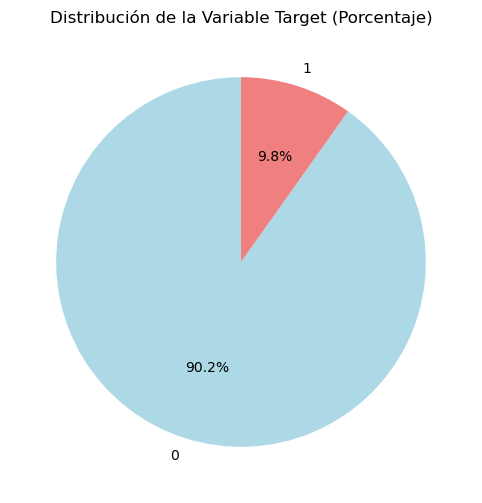

In [83]:
target = df['target']

# Contar la frecuencia de cada clase en la variable target
class_distribution = target.value_counts()
print("\nDistribución de Clases en la Variable Target:")
print(class_distribution)

# Calcular el porcentaje de cada clase
class_percentage = target.value_counts(normalize=True) * 100
print("\nPorcentaje de Cada Clase en la Variable Target:")
print(class_percentage)

plt.figure(figsize=(8, 6))
target.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title("Distribución de la Variable Target (Porcentaje)")
plt.ylabel('')
plt.show()

La variable target muestra una distribución altamente desequilibrada. Este desbalance indica que la mayoría de los datos pertenece a la clase 0, lo que puede generar problemas en los modelos de clasificación, que tienden a la generalización y sesgarse hacia la clase mayoritaria. En tales situaciones, las métricas tradicionales como la precisión general pueden ser engañosas, ya que los modelos pueden simplemente predecir la clase mayoritaria y obtener un alto "accuracy", pero un bajo desempeño en identificar correctamente la clase minoritaria (1). Por lo tanto, se optará a emplear métodos de balance.

#### 2.2.2 Análisis de variable 'Sexo'


Distribución de Clases en la Variable Sexo:
Sexo
H    5589
M    4411
Name: count, dtype: int64

Porcentaje de Cada Clase en la Variable Sexo:
Sexo
H   55.89
M   44.11
Name: proportion, dtype: float64


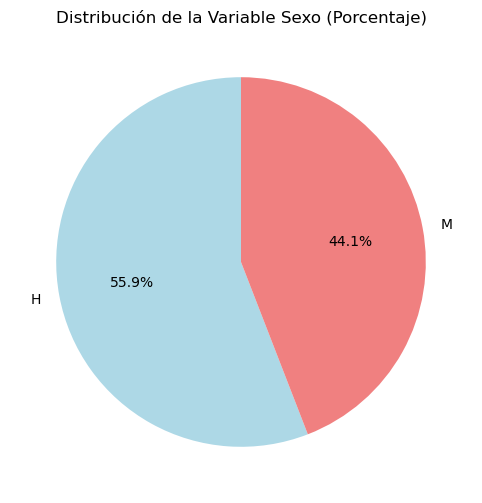


 Nulos en la Variable Sexo: Sexo    0
dtype: int64


In [85]:
sexo = df['Sexo']

# Contar la frecuencia de cada clase en la variable target
class_distribution = sexo.value_counts()
print("\nDistribución de Clases en la Variable Sexo:")
print(class_distribution)

# Calcular el porcentaje de cada clase
class_percentage = sexo.value_counts(normalize=True) * 100
print("\nPorcentaje de Cada Clase en la Variable Sexo:")
print(class_percentage)

plt.figure(figsize=(8, 6))
sexo.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title("Distribución de la Variable Sexo (Porcentaje)")
plt.ylabel('')
plt.show()

nulos_columnas_especificas = df[['Sexo']].isnull().sum()
print("\n Nulos en la Variable Sexo:", nulos_columnas_especificas)

#### 2.2.3 Análisis de variable característica 'Region'


Distribución de Clases en la Variable Region:
Region
13.00    6519
8.00      725
5.00      665
10.00     395
9.00      391
12.00     285
7.00      207
1.00      194
4.00      179
2.00      164
6.00      122
11.00      84
3.00       62
Name: count, dtype: int64

Porcentaje de Cada Clase en la Variable Region:
Region
13.00   65.24
8.00     7.26
5.00     6.66
10.00    3.95
9.00     3.91
12.00    2.85
7.00     2.07
1.00     1.94
4.00     1.79
2.00     1.64
6.00     1.22
11.00    0.84
3.00     0.62
Name: proportion, dtype: float64


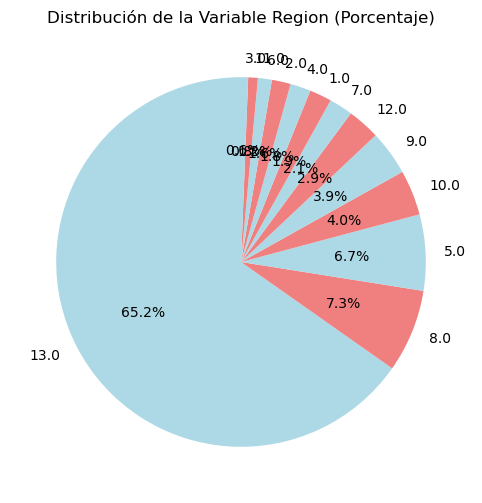

In [91]:
region = df['Region']


class_distribution = region.value_counts()
print("\nDistribución de Clases en la Variable Region:")
print(class_distribution)


class_percentage = region.value_counts(normalize=True) * 100
print("\nPorcentaje de Cada Clase en la Variable Region:")
print(class_percentage)

plt.figure(figsize=(8, 6))
region.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title("Distribución de la Variable Region (Porcentaje)")
plt.ylabel('')
plt.show()

In [88]:
nulos_columnas_especificas = df[['Region']].isnull().sum()
print("\n Nulos en la Variable Region:", nulos_columnas_especificas)


 Nulos en la Variable Region: Region    8
dtype: int64


Esta variable cuenta con observaciones nulas, por lo que se filtrarán en la próxima etapa. Adempas, se aplicará una imputación mediante KNN para los valores nulos

#### 2.2.4 Análisis de variable característica 'EeccNac_T12'

Casos perdidos en EeccNac_T12: 1245
Estadísticos descriptivos para la variable 'EeccNac_T12':
Media: 211970.9279268989
Mediana: 86815.0
Moda: 0.0
Desviación Estándar: 326148.1122818166
Varianza: 106372591144.99245
Valor Mínimo: -1303628.0
Valor Máximo: 3529565.0
Percentil 25: 17408.0
Percentil 50 (Mediana): 86815.0
Percentil 75: 271541.0
-------------------------------------------------------


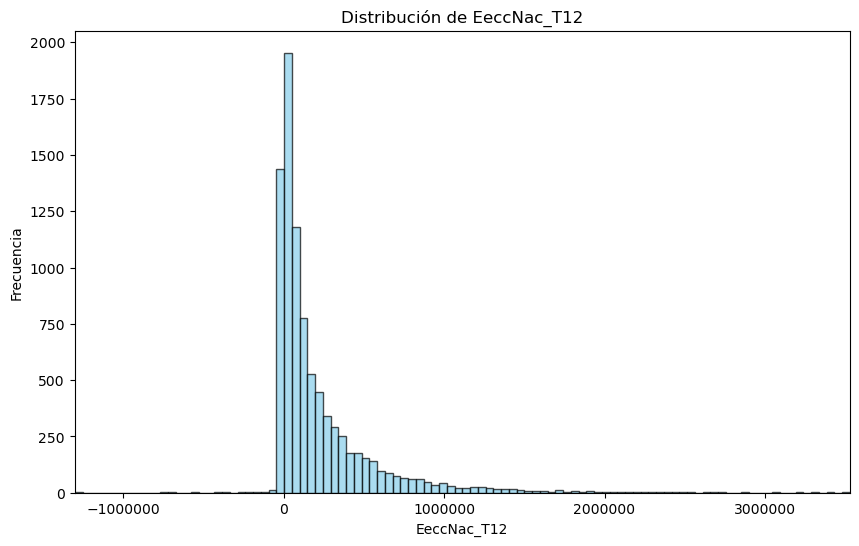

In [92]:
## Estadísticos de EeccNac_T12
casos_perdidos_eecc = df['EeccNac_T12'].isna().sum()
print(f'Casos perdidos en EeccNac_T12: {casos_perdidos_eecc}')
EeccNac_T12 = df['EeccNac_T12']
media = EeccNac_T12.mean()
mediana = EeccNac_T12.median()
moda = EeccNac_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = EeccNac_T12.std()
varianza = EeccNac_T12.var()
valor_minimo = EeccNac_T12.min()
valor_maximo = EeccNac_T12.max()
percentil_25 = EeccNac_T12.quantile(0.25)
percentil_50 = EeccNac_T12.quantile(0.50)  #  mediana
percentil_75 = EeccNac_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'EeccNac_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de EeccNac_T12

plt.figure(figsize=(10, 6))
plt.hist(EeccNac_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de EeccNac_T12')
plt.xlabel('EeccNac_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable EeccNac_T12 muestra una distribución con los siguientes aspectos clave: 
* La media es 211,970.93, significativamente mayor que la mediana (86,815) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (326,148.11), lo que refleja una gran variabilidad en los datos.
* existe asimetría, pues mientras el 25% de los datos está por debajo de 17,408, el 75% se sitúa por debajo de 271,541. 
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulo mediante la diferencia marcada entre media y mediana.

La presencia de valores outliers y perdidos implica el empleo de la transformación y limpieza de la variable

#### 2.2.5 Análisis de variable característica 'Fac_T12'

Casos perdidos en Fac_T12: 1245
Estadísticos descriptivos para la variable 'Fac_T12':
Media: 74667.45079640204
Mediana: 26217.0
Moda: 0.0
Desviación Estándar: 141439.92824014745
Varianza: 20005253300.578056
Valor Mínimo: -39593.0
Valor Máximo: 4631740.5859
Percentil 25: 0.0
Percentil 50 (Mediana): 26217.0
Percentil 75: 93885.0
-------------------------------------------------------


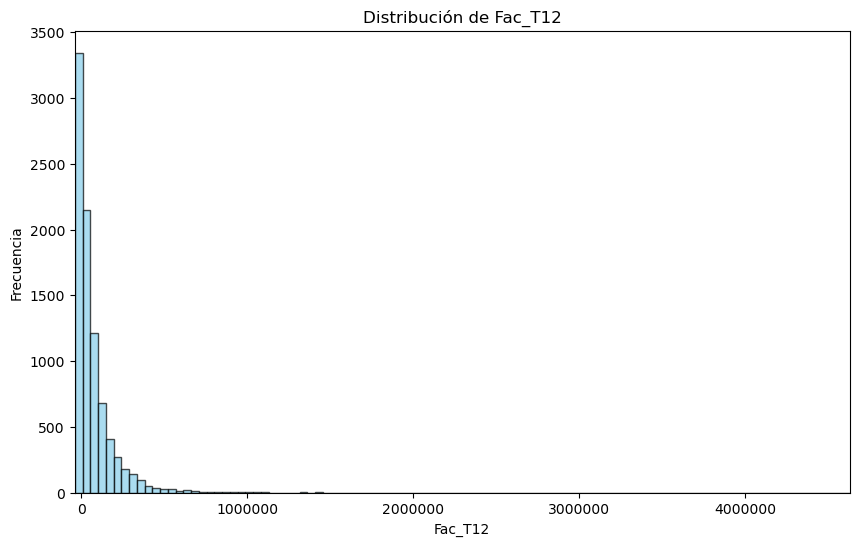

In [93]:
## Estadísticos de Fac_T12
casos_perdidos_Fac_T12 = df['Fac_T12'].isna().sum()
print(f'Casos perdidos en Fac_T12: {casos_perdidos_Fac_T12}')
Fac_T12 = df['Fac_T12']
media = Fac_T12.mean()
mediana = Fac_T12.median()
moda = Fac_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = Fac_T12.std()
varianza = Fac_T12.var()
valor_minimo = Fac_T12.min()
valor_maximo = Fac_T12.max()
percentil_25 = Fac_T12.quantile(0.25)
percentil_50 = Fac_T12.quantile(0.50)  #  mediana
percentil_75 = Fac_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'Fac_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de Fac_T12

plt.figure(figsize=(10, 6))
plt.hist(Fac_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de Fac_T12')
plt.xlabel('Fac_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable Fac_T12 muestra una distribución con los siguientes aspectos clave:

* La media es 74,667.45, significativamente mayor que la mediana (26,217) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (141,439.93), lo que refleja una gran variabilidad en los datos.
* Existe asimetría, pues mientras el 25% de los datos está por debajo de 0.0, el 75% se sitúa por debajo de 93,885.
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulos, como se evidencia en la diferencia marcada entre media y mediana.

La presencia de valores outliers y 1,245 casos perdidos implica el empleo de la transformación y limpieza de la variable.

#### 2.2.6 Análisis de variable característica 'Col_T12'

Casos perdidos en UsoL1_T12: 1245
Estadísticos descriptivos para la variable 'Col_T12':
Media: 326809.4152495717
Mediana: 125872.96
Moda: 0.0
Desviación Estándar: 611929.1275720266
Varianza: 374457257171.0616
Valor Mínimo: 0.0
Valor Máximo: 10493610.41
Percentil 25: 26995.0
Percentil 50 (Mediana): 125872.96
Percentil 75: 376682.0
-------------------------------------------------------


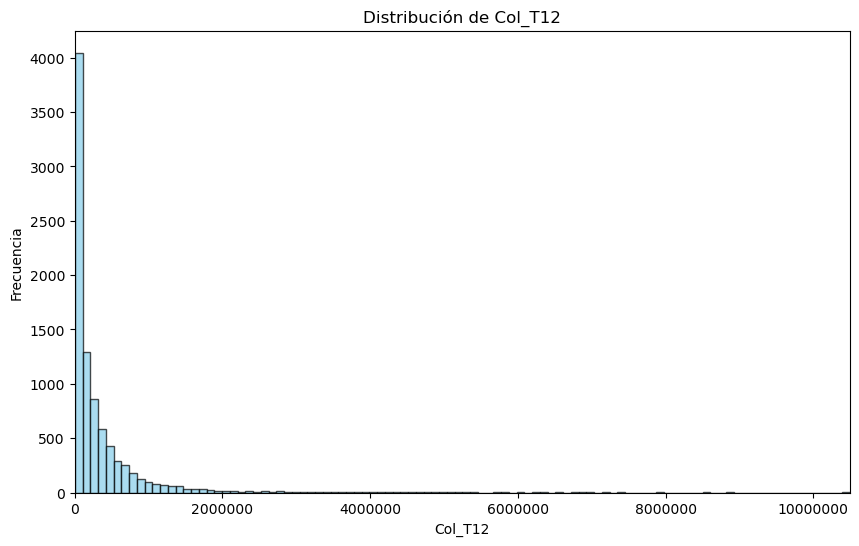

In [94]:
## Estadísticos de Col_T12
casos_perdidos_Col_T12 = df['Col_T12'].isna().sum()
print(f'Casos perdidos en UsoL1_T12: {casos_perdidos_Col_T12}')
Col_T12 = df['Col_T12']
media =Col_T12.mean()
mediana = Col_T12.median()
moda = Col_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = Col_T12.std()
varianza = Col_T12.var()
valor_minimo = Col_T12.min()
valor_maximo = Col_T12.max()
percentil_25 = Col_T12.quantile(0.25)
percentil_50 = Col_T12.quantile(0.50)  #  mediana
percentil_75 = Col_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'Col_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de Col_T12

plt.figure(figsize=(10, 6))
plt.hist(Col_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de Col_T12')
plt.xlabel('Col_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable Col_T12 muestra una distribución con los siguientes aspectos clave:

* La media es 326,809.42, significativamente mayor que la mediana (125,872.96) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (611,929.13), lo que refleja una gran variabilidad en los datos.
* Existe asimetría, pues mientras el 25% de los datos está por debajo de 26,995.0, el 75% se sitúa por debajo de 376,682.0.
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulos, destacada por la diferencia marcada entre media y mediana.

La presencia de valores outliers y 1,245 casos perdidos implica el empleo de la transformación y limpieza de la variable.

#### 2.2.7 Análisis de variable característica 'UsoL1_T12'

Casos perdidos en UsoL1_T12: 1245
Estadísticos descriptivos para la variable 'UsoL1_T12':
Media: 202949.92729069103
Mediana: 75564.0
Moda: 0.0
Desviación Estándar: 319921.8540075642
Varianza: 102349992671.6372
Valor Mínimo: -1303628.0
Valor Máximo: 3544565.0
Percentil 25: 7092.0
Percentil 50 (Mediana): 75564.0
Percentil 75: 270205.54000000004
-------------------------------------------------------


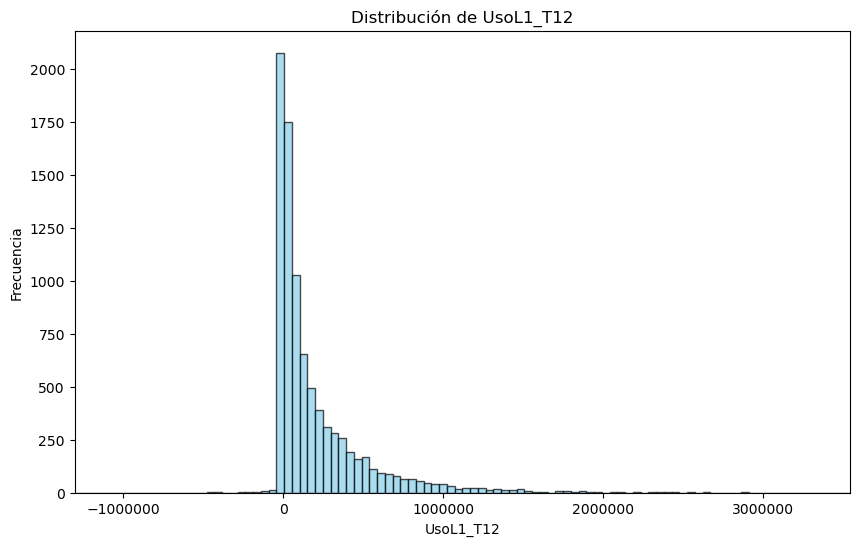

In [95]:
## Estadísticos de UsoL1_T12
casos_perdidos_UsoL1_T12 = df['UsoL1_T12'].isna().sum()
print(f'Casos perdidos en UsoL1_T12: {casos_perdidos_UsoL1_T12}')
UsoL1_T12 = df['UsoL1_T12']
media =UsoL1_T12.mean()
mediana = UsoL1_T12.median()
moda = UsoL1_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = UsoL1_T12.std()
varianza = UsoL1_T12.var()
valor_minimo = UsoL1_T12.min()
valor_maximo = UsoL1_T12.max()
percentil_25 = UsoL1_T12.quantile(0.25)
percentil_50 = UsoL1_T12.quantile(0.50)  #  mediana
percentil_75 = UsoL1_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'UsoL1_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de UsoL1_T12

plt.figure(figsize=(10, 6))
plt.hist(UsoL1_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de UsoL1_T12')
plt.xlabel('UsoL1_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable UsoL1_T12 muestra una distribución con los siguientes aspectos clave:

* La media es 202,949.93, significativamente mayor que la mediana (75,564) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (319,921.85), lo que refleja una gran variabilidad en los datos.
* Existe asimetría, pues mientras el 25% de los datos está por debajo de 7,092.0, el 75% se sitúa por debajo de 270,205.54.
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulos, resaltada por la diferencia marcada entre media y mediana.

La presencia de valores outliers y 1,245 casos perdidos implica el empleo de la transformación y limpieza de la variable.

# 3. Preparación de datos


En este momento, se llevará a cabo un proceso de preparación que incluye la identificación y tratamiento de outliers en las variables seleccionadas: EeccNac_T12, Fac_T12, UsoL1_T12 y Col_T12. Se Utilizará el método del rango intercuartílico (IQR) para detectar los valores atípicos. Primero, se calculará el primer cuartil (Q1) y el tercer cuartil (Q3) de cada variable, y luego se determinará el IQR. A partir de esto, se establecerán los límites inferior y superior para identificar los outliers, que serán convertidos a valores NaN en el nuevo DataFrame. Este proceso permitirá una mejor calidad de los datos y una análisis más robusto.

## 3.1 Transformación de datos para tratar outliers

In [96]:
variables_a_filtrar = ['EeccNac_T12', 'Fac_T12', 'UsoL1_T12', 'Col_T12']

for variable in variables_a_filtrar:
    print(f"DataFrame antes de convertir outliers a NaN para {variable}:")
    print(df[variable].describe())

    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1

    # Definir Q
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar outliers
    df[f'{variable}_filtrado'] = df[variable].mask((df[variable] < limite_inferior) | (df[variable] > limite_superior))

    print('Datos NaN antes de filtrar outliers: ', df[variable].isnull().sum())
    print("===============================================")
    print(f"DataFrame después de convertir outliers a NaN para {variable}:")
    print(df[f'{variable}_filtrado'].describe())
    print('Datos NaN después de filtrar outliers: ', df[f'{variable}_filtrado'].isnull().sum())
    print("\n")

DataFrame antes de convertir outliers a NaN para EeccNac_T12:
count       8755.00
mean      211970.93
std       326148.11
min     -1303628.00
25%        17408.00
50%        86815.00
75%       271541.00
max      3529565.00
Name: EeccNac_T12, dtype: float64
Datos NaN antes de filtrar outliers:  1245
DataFrame después de convertir outliers a NaN para EeccNac_T12:
count      8012.00
mean     134040.44
std      158262.05
min     -359544.00
25%       13201.25
50%       70920.50
75%      204719.50
max      652482.00
Name: EeccNac_T12_filtrado, dtype: float64
Datos NaN después de filtrar outliers:  1988


DataFrame antes de convertir outliers a NaN para Fac_T12:
count      8755.00
mean      74667.45
std      141439.93
min      -39593.00
25%           0.00
50%       26217.00
75%       93885.00
max     4631740.59
Name: Fac_T12, dtype: float64
Datos NaN antes de filtrar outliers:  1245
DataFrame después de convertir outliers a NaN para Fac_T12:
count     8049.00
mean     44577.67
std      57272.5

## 3.2 Limpieza e imputación de datos

A continuación, se llevará a cabo un proceso de limpieza e imputación de datos para las variables filtradas: EeccNac_T12_filtrado, Fac_T12_filtrado, UsoL1_T12_filtrado y Col_T12_filtrado. Se utilizará el método de imputación basado en k-vecinos más cercanos (KNN) para abordar los valores perdidos en estas variables. Primero, se mostrará un resumen descriptivo de cada variable antes de la imputación, seguido de la creación de un imputador KNN con 5 vecinos. Luego, se realizará la imputación y se agregarán las variables imputadas al DataFrame original. Finalmente, se presentará un resumen descriptivo de cada variable después de la imputación y la cantidad de datos perdidos. Este procedimiento permitirá mejorar la integridad de los datos y facilitar un análisis posterior más preciso.

In [97]:
# Definir las variables a imputar
variables_a_imputar = ['EeccNac_T12_filtrado', 'Fac_T12_filtrado', 'UsoL1_T12_filtrado', 'Col_T12_filtrado', 'Region']

# Imputación de datos perdidos
for variable in variables_a_imputar:
    print(f"DataFrame antes de imputar para {variable}:")
    print(df[variable].describe())

    # Crear el imputador KNN
    imputer = KNNImputer(n_neighbors=5)

    # Preparar los datos para imputar, seleccionando solo las variables filtradas
    df_imputar = df[[variable]]

    # Realizar la imputación
    df_imputado = imputer.fit_transform(df_imputar)

    # Convertir el resultado a DataFrame
    df_variable_imputada = pd.DataFrame(df_imputado, columns=[f'{variable}_imputado'])

    # Agregar la variable imputada al DataFrame original
    df[f'{variable}_imputado'] = df_variable_imputada[f'{variable}_imputado']

    print("===============================================")
    print(f"DataFrame después de imputar para {variable}:")
    print(df[f'{variable}_imputado'].describe())
    print('Datos NaN: ', df[f'{variable}_imputado'].isnull().sum())
    print("\n")

DataFrame antes de imputar para EeccNac_T12_filtrado:
count      8012.00
mean     134040.44
std      158262.05
min     -359544.00
25%       13201.25
50%       70920.50
75%      204719.50
max      652482.00
Name: EeccNac_T12_filtrado, dtype: float64
DataFrame después de imputar para EeccNac_T12_filtrado:
count     10000.00
mean     134040.44
std      141658.24
min     -359544.00
25%       24410.00
50%      118744.00
75%      157116.00
max      652482.00
Name: EeccNac_T12_filtrado_imputado, dtype: float64
Datos NaN:  0


DataFrame antes de imputar para Fac_T12_filtrado:
count     8049.00
mean     44577.67
std      57272.50
min     -39593.00
25%          0.00
50%      20000.00
75%      70891.00
max     234504.00
Name: Fac_T12_filtrado, dtype: float64
DataFrame después de imputar para Fac_T12_filtrado:
count    10000.00
mean     44577.67
std      51382.10
min     -39593.00
25%          0.00
50%      40157.00
75%      55300.00
max     234504.00
Name: Fac_T12_filtrado_imputado, dtype: float6

Los resultados de la imputación muestran que el proceso fue exitoso para todas las variables analizadas (EeccNac_T12_filtrado, Fac_T12_filtrado, UsoL1_T12_filtrado y Col_T12_filtrado), ya que no se registraron datos faltantes en las variables imputadas.  La imputación ha permitido llenar los valores perdidos en todas las variables, mejorando la cantidad de datos disponibles para el análisis y ajustando los valores centrales y la variabilidad. Estos cambios sugieren que la imputación ha tenido un impacto positivo en la calidad de los datos.

Lo anterior se puede observar al generar boxplots con las variables características en la fase previa a la transformación e imputación, y la posterior. Anteriormente, no se podía representar los datos de las variables mediante el gráfico de caja por los problemas que presentaban. Actualmente, esto se resuelve generándose los boxplots. Sin embargo, es relevante señalar que aparecieron un número importante de observaciones outliers.

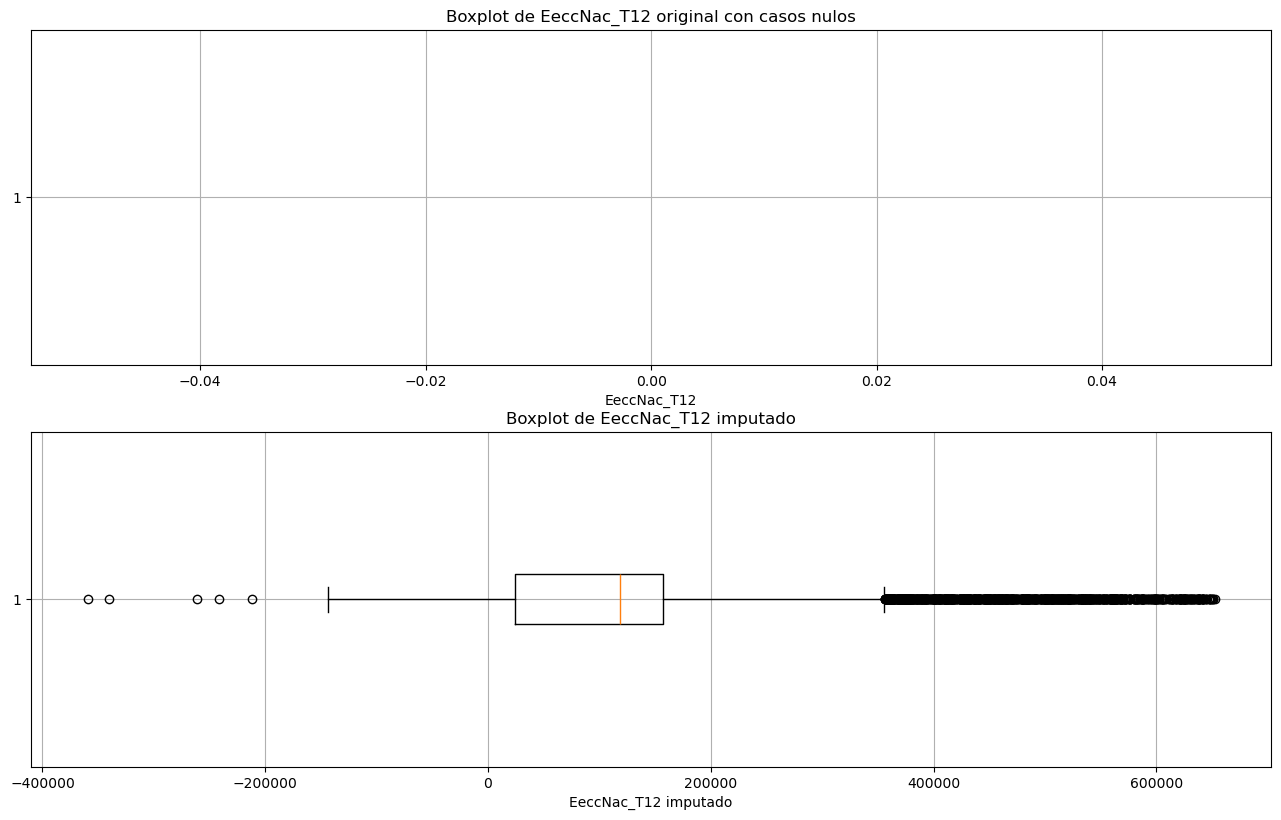

In [98]:
# Crear boxplots para cada variable
plt.figure(figsize=(16, 20))

# Boxplot para EeccNac_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['EeccNac_T12'], vert=False)
plt.title('Boxplot de EeccNac_T12 original con casos nulos')
plt.xlabel('EeccNac_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

# Boxplot para EeccNac_T12 imputado
plt.subplot(4, 1, 2)
plt.boxplot(df['EeccNac_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de EeccNac_T12 imputado')
plt.xlabel('EeccNac_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

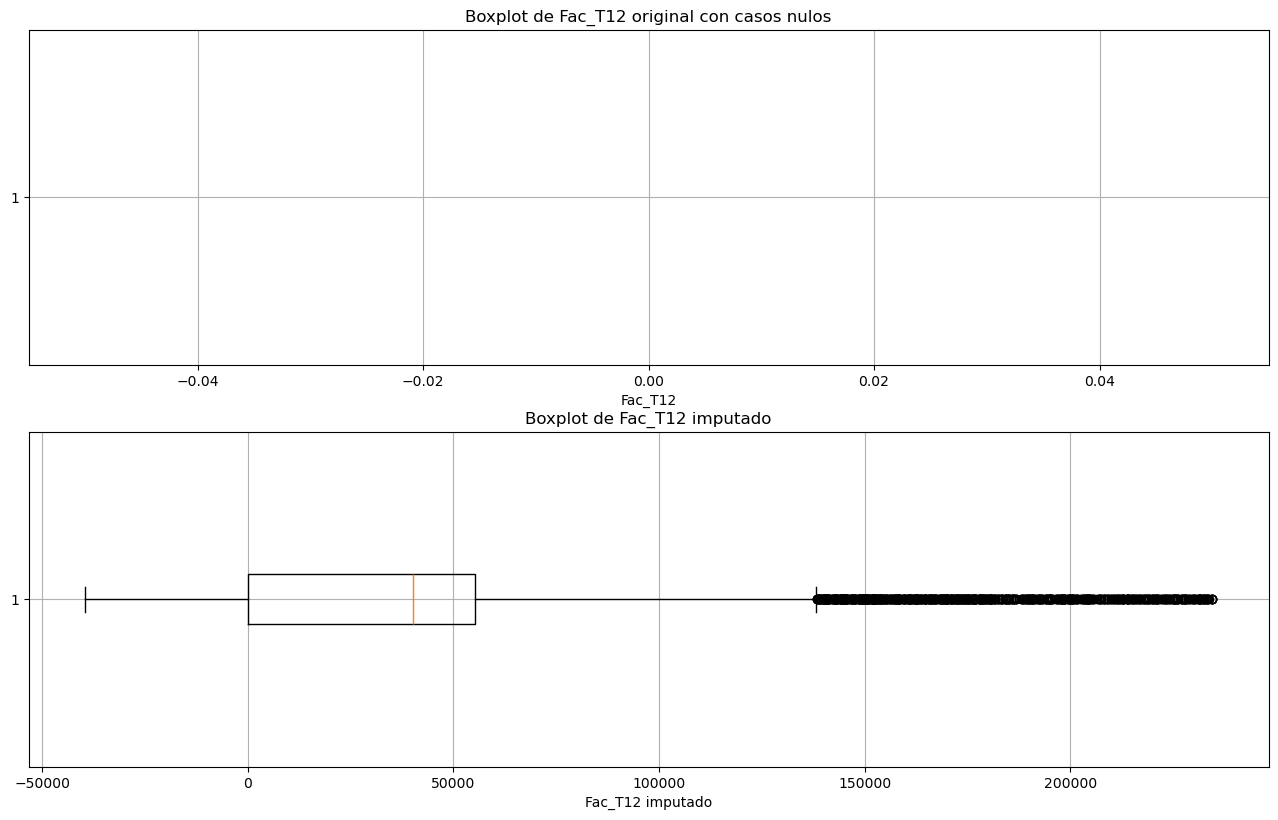

In [99]:
plt.figure(figsize=(16, 20))

# Boxplot para Fac_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['Fac_T12'], vert=False)
plt.title('Boxplot de Fac_T12 original con casos nulos')
plt.xlabel('Fac_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

# Boxplot para Fac_T12 imputado
plt.subplot(4, 1, 2)
plt.boxplot(df['Fac_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de Fac_T12 imputado')
plt.xlabel('Fac_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

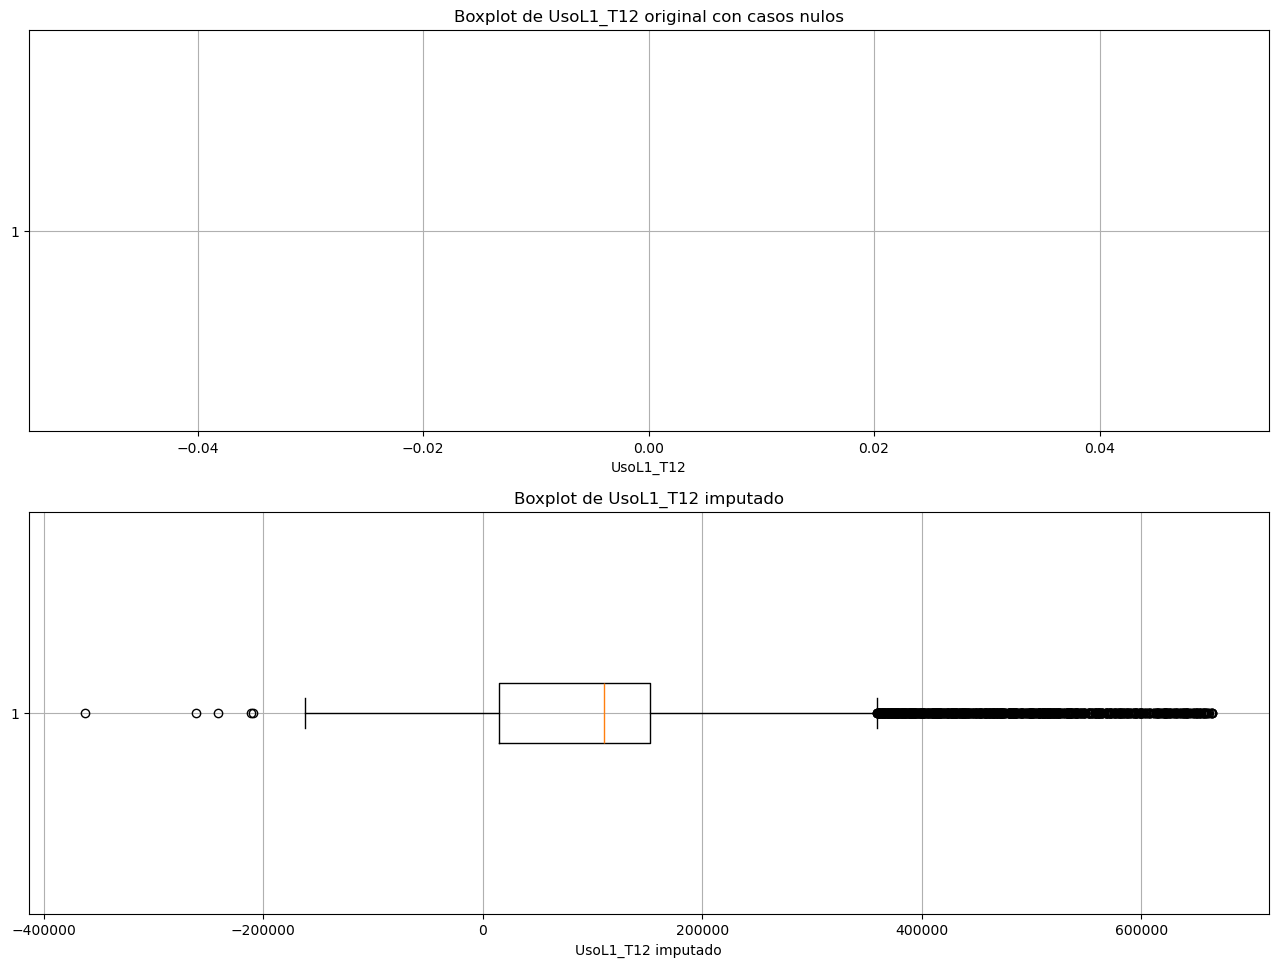

In [100]:
plt.figure(figsize=(16, 24))
# Boxplot para UsoL1_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['UsoL1_T12'], vert=False)
plt.title('Boxplot de UsoL1_T12 original con casos nulos')
plt.xlabel('UsoL1_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

plt.subplot(4, 1, 2)
plt.boxplot(df['UsoL1_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de UsoL1_T12 imputado')
plt.xlabel('UsoL1_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()


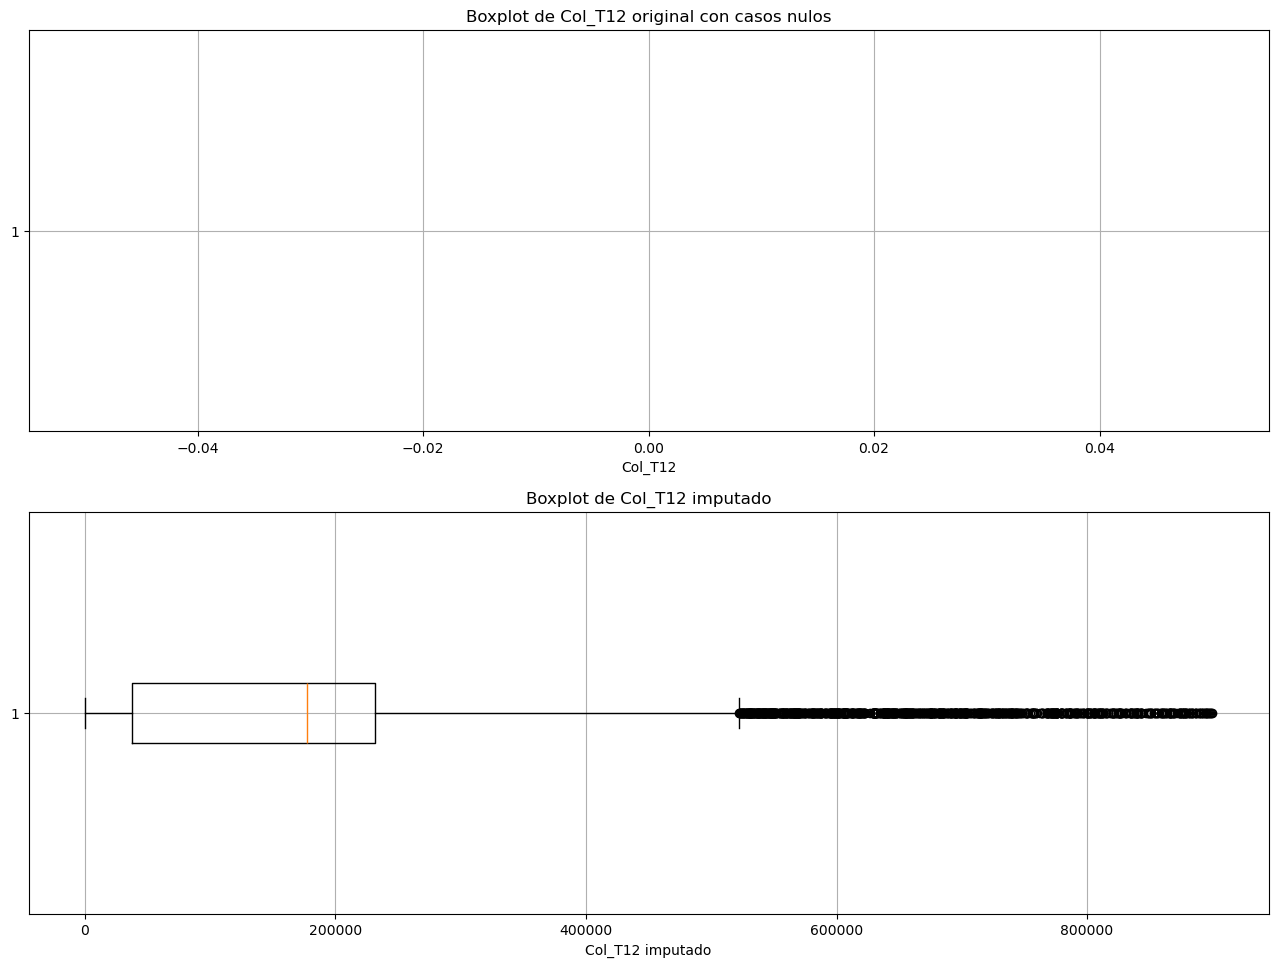

In [101]:
plt.figure(figsize=(16, 24))
# Boxplot para Col_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['Col_T12'], vert=False)
plt.title('Boxplot de Col_T12 original con casos nulos')
plt.xlabel('Col_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

plt.subplot(4, 1, 2)
plt.boxplot(df['Col_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de Col_T12 imputado')
plt.xlabel('Col_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

### 3.3 Normalización de variables características

La normalización sirve para ajustar las características numéricas de los datos en una escala común, lo cual es crucial en ciertos modelos de aprendizaje automático, especialmente aquellos que calculan distancias entre los puntos de datos. En este caso, resulta fundamenta realizar este proceso para ajustar de manera óptima las predicciones hacia la variable target.

In [102]:
features_normalizadas = ['EeccNac_T12_filtrado_imputado', 
                          'Fac_T12_filtrado_imputado', 
                          'UsoL1_T12_filtrado_imputado', 
                          'Col_T12_filtrado_imputado']

# Objeto para estadizar o normalizar

scaler = StandardScaler()

# Normalización 

df[features_normalizadas] = scaler.fit_transform(df[variables_a_normalizar])
print(df[features_normalizadas].head())

   EeccNac_T12_filtrado_imputado  Fac_T12_filtrado_imputado  \
0                           0.00                       0.21   
1                           0.78                      -0.48   
2                          -0.28                       1.54   
3                           1.59                      -0.00   
4                           0.70                       1.82   

   UsoL1_T12_filtrado_imputado  Col_T12_filtrado_imputado  
0                         0.00                       2.52  
1                         0.79                       0.94  
2                        -0.24                      -0.34  
3                         1.58                       0.80  
4                        -0.43                      -0.06  


## 4. Selección de características

En esta fase, se procederá a la selección de características para identificar y retener las variables más relevantes que contribuyen a la explicación de la variabilidad en el conjunto de datos. El objetivo es reducir la dimensionalidad del conjunto de datos y mejorar la eficiencia y efectividad de los modelos de análisis posteriores. La técnica a utilizar es la Correlación de Pearson.

### 4.1 Análisis de correlaciones entre features


Matriz de correlación:
                                EeccNac_T12_filtrado_imputado  \
EeccNac_T12_filtrado_imputado                           1.00   
Fac_T12_filtrado_imputado                               0.15   
UsoL1_T12_filtrado_imputado                             0.90   
Col_T12_filtrado_imputado                               0.63   

                               Fac_T12_filtrado_imputado  \
EeccNac_T12_filtrado_imputado                       0.15   
Fac_T12_filtrado_imputado                           1.00   
UsoL1_T12_filtrado_imputado                         0.17   
Col_T12_filtrado_imputado                           0.16   

                               UsoL1_T12_filtrado_imputado  \
EeccNac_T12_filtrado_imputado                         0.90   
Fac_T12_filtrado_imputado                             0.17   
UsoL1_T12_filtrado_imputado                           1.00   
Col_T12_filtrado_imputado                             0.65   

                               Col_T12_filt

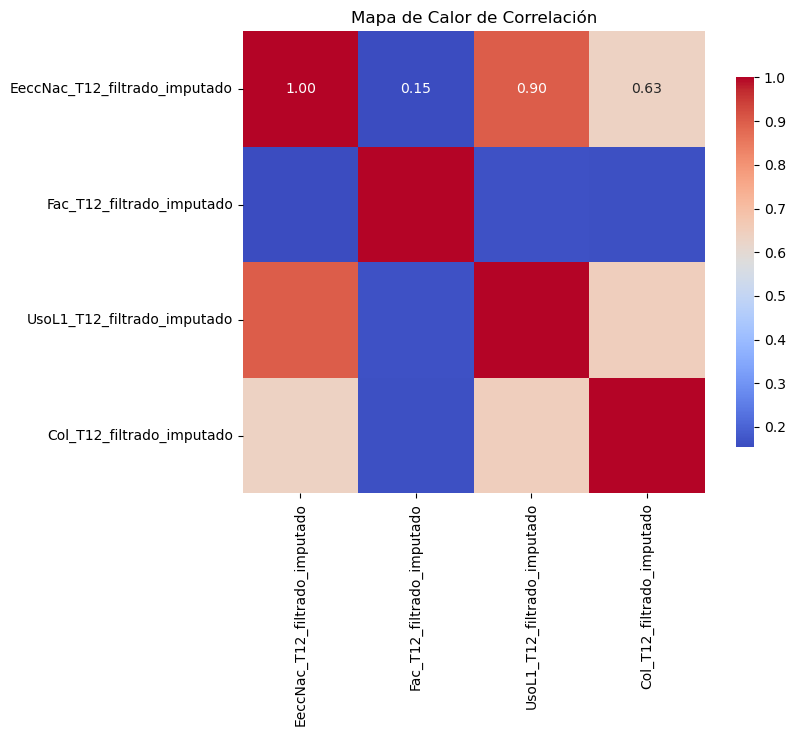

In [103]:
## Correlaciones
correlation_matrix = df[features_normalizadas].corr(method='pearson')


print("Matriz de correlación:\n", correlation_matrix)

## Gráfico de mapa de color

# Tamaño de la figura
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, 
             xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.index)

# Título
plt.title('Mapa de Calor de Correlación')

# Mostrar el gráfico
plt.show()

El análisis de correlación revela que EeccNac_T12_filtrado_imputado y UsoL1_T12_filtrado_imputado son las variables más fuertemente relacionadas. Si bien esto puede parecer positivo para la mejora posterior del rendimiento de los modelos, se debe tener en cuenta el problema de la multicolinealidad (que afecta también a modelos de clasificación).

Las correlaciones moderadas entre Col_T12_filtrado_imputado y las otras variables también son dignas de mención, mientras que Fac_T12_filtrado_imputado presenta interacciones más débiles, sugiriendo que podría ser menos relevante en este contexto.

Al presentarse estos hallazgos, se empleará Backward Selection para la reducción de las variables, con el fin de dar mayor consistencia al proceso de selección de características.

C:\Users\Adolfo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adolfo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adolfo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adolfo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

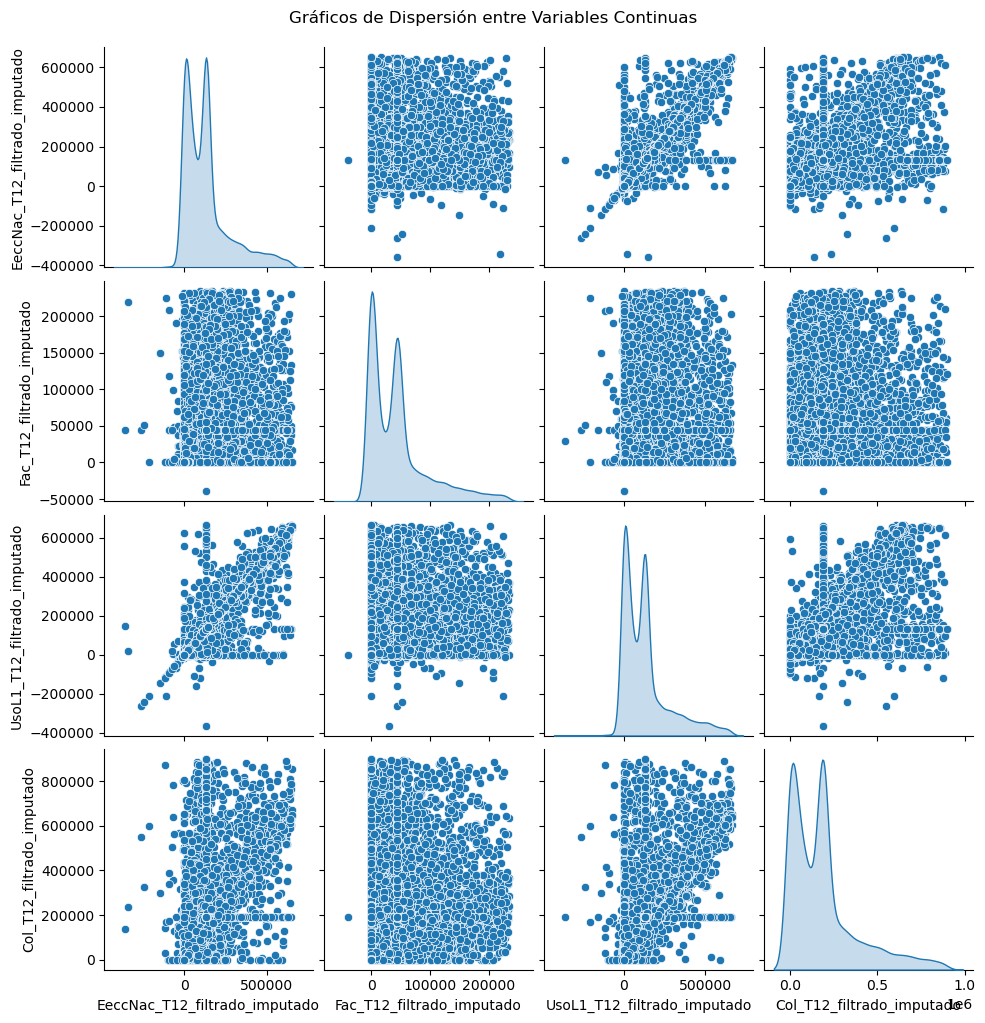

In [38]:
# Pairplot
sns.pairplot(continuous_vars, diag_kind='kde')  # diag_kind='kde' muestra la densidad en la diagonal
plt.suptitle('Gráficos de Dispersión entre Variables Continuas', y=1.02)  # Título para el gráfico
plt.show()

En este momento, se va a revisar la correlación de 'Region' y 'Sexo' para evaluar la posibilidad de emplear estas variables en el modelo. Se empleará la prueba de chi-cuadrado.

In [104]:
contingency_table3 = pd.crosstab(df['Sexo'], df['Region'])

# Calcular el estadístico Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table3)

# Calcular el coeficiente de Phi
phi = np.sqrt(chi2 / df.shape[0])

print("Coeficiente de Phi:", phi)

Coeficiente de Phi: 0.050731578813950726


Si bien se puede afirmar que no existe una relación entre Sexo y Región, hay una cercanía al dígito que permite establecer la hipótesis de existencia de relación. Esto puede ayudar la predicciones de los modelos que se generarán, pues no se observa colinealidad pero si una tendencia de cercanía entre estas características.

### 4.2 Wrapped Backward Selection

La selección de características mediante Wrapped Backward Selection es una técnica efectiva para identificar las variables más relevantes en un conjunto de datos. Esta técnica utiliza un modelo de regresión logística para evaluar qué características mantener y cuáles eliminar, basándose en su contribución a la precisión del modelo. Es importante indicar que no se trabajará con los predictores cualitativos en esta oportunidad.

In [105]:
# Features
variables_predictoras = [
    'EeccNac_T12_filtrado_imputado',
    'Fac_T12_filtrado_imputado',
    'UsoL1_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado'
]

# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Constante para término de selección
X = df[variables_predictoras]
X = sm.add_constant(X)


In [106]:
# Función para Backward Selection
def backward_selection(X, y, significance_level=0.05):
    features = X.columns.tolist()
    
    while len(features) > 0:
        model = sm.Logit(y, X[features])
        result = model.fit(disp=0)
        
        p_values = result.pvalues
        
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            features.remove(p_values.idxmax())
        else:
            break
    
    return features

# Ejecutar Backward Selection
selected_features = backward_selection(X, y)
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['const', 'EeccNac_T12_filtrado_imputado', 'Col_T12_filtrado_imputado']


A través del proceso de Backward Selection, se identificó que estas características ('EeccNac_T12_filtrado_imputado' y 'Col_T12_filtrado_imputado') presentaban valores p significativos, lo que indica que tienen un impacto significativo en la predicción del resultado binario. Además, la alta correlación observada entre estas variables y la variable objetivo sugiere que están bien alineadas con el fenómeno que se busca modelar.

Fac_T12_filtrado_imputado es la mejor opción entre los modelos analizados, ya que ofrece un mejor equilibrio en la precisión y el recall. Aunque el F1-score es bajo, es el más alto entre los cuatro modelos y tiene el mejor rendimiento general.

Sin embargo, es importante tener en cuenta que todos los modelos tienen limitaciones en el rendimiento para la clase 1. Si se puede, considera mejorar la representación de la clase 1 a través de técnicas de muestreo o explorar algoritmos que se adaptan mejor a conjuntos de datos desbalanceados.


## 5. Modelado

### 5.1 Selección de técnica de modelado

Como la varaible target es binaria, la selección de modelos de clasificación como regresión logística, máquinas de soporte vectorial (SVM), k-vecinos más cercanos (KNN) y árboles de decisión es una estrategia robusta para abordar problemas de clasificación de este tipo. 

La regresión logística es particularmente adecuada para este tipo de tareas, ya que se centra en modelar la probabilidad de pertenencia a una de las dos clases y proporciona interpretaciones claras a través de sus coeficientes. Sin embargo, al presentarse una variable target desbalanceada, puede resultar incompatible para la necesidad de este proyecto.

Este tipo de modelo se va a relacionar con Wrapped Backward Selection permite optimizar la selección de características, asegurando que solo las variables más relevantes se utilicen en el modelo, lo que mejora la interpretabilidad y el rendimiento del mismo. 

Por otro lado, SVM es conocido por su capacidad para manejar datos no lineales mediante el uso de kernels, lo que le permite encontrar límites de decisión complejos. 

KNN, siendo un enfoque basado en la distancia, es intuitivo y no requiere suposiciones sobre la distribución de los datos, lo que lo hace versátil en diversas situaciones.

Finalmente, los árboles de decisión se empleara de manera alternativa, pues es un modelo de clasificación para variables target de múltiples valores.

**En cuanto a la regresión lineal, aunque es una técnica ampliamente utilizada para problemas de regresión, no es adecuada para problemas de clasificación binaria. La regresión lineal no tiene en cuenta la naturaleza discreta de la variable objetivo, lo que podría llevar a predicciones engañosas y a un rendimiento deficiente en la clasificación. Por lo tanto, la elección de modelos diseñados específicamente para clasificación, como los mencionados, es más apropiada para este tipo de problemas, ya que están optimizados para manejar la naturaleza de la variable objetivo binaria.**



### 5.2 Selección de datos de prueba

In [107]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado'
]

# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [108]:
# Features cualitativos

# Transformar 'Sexo' a valores binarios (0 y 1)
df['Sexo'] = df['Sexo'].map({'M': 0, 'H': 1})

features_cuali = [
    'Sexo',
    'Col_T12_filtrado_imputado'
]

#Generar dummies para Region
dummies_region = pd.get_dummies(df['Region'], prefix='Region', drop_first=True)
df = pd.concat([df, dummies_region], axis=1)


In [110]:
# Features final
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

In [111]:
# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Separar las variables predictoras y la variable objetivo
X = df[features_cuali]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 5.3 Ejecución de modelos

#### 5.3.1 Regresión logística

##### Fase 1

In [112]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target']  

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [113]:
# Crear el modelo de regresión logística
model = LogisticRegression()    #(class_weight='balanced')

# Ajustar el modelo
model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Predecir probabilidades para la curva ROC
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Evaluar el modelo
print("Resultados del modelo de regresión logística:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("=========================================")




Resultados del modelo de regresión logística:
Matriz de Confusión:
[[2669    0]
 [ 331    0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2669
           1       0.00      0.00      0.00       331

    accuracy                           0.89      3000
   macro avg       0.44      0.50      0.47      3000
weighted avg       0.79      0.89      0.84      3000



C:\Users\Adolfo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adolfo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adolfo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


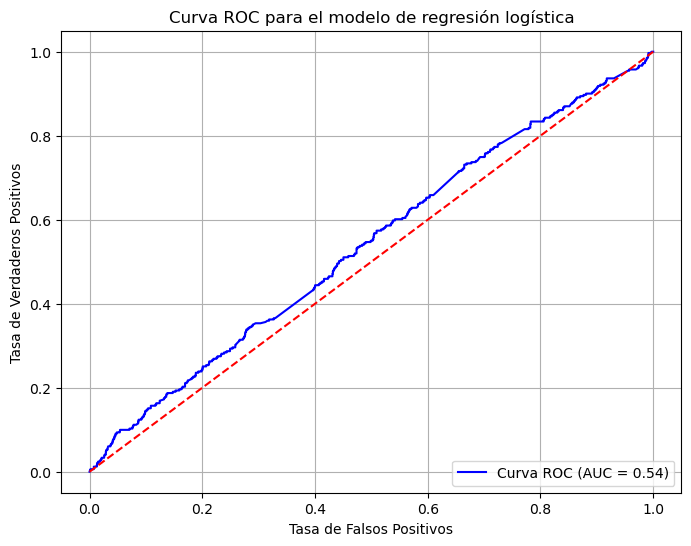

In [114]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el modelo de regresión logística')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Los resultados del modelo de regresión logística muestran un claro overfitting hacia la clase negativa, ya que la matriz de confusión indica que todas las predicciones fueron correctas para la clase 0, mientras que no se identificaron instancias de la clase 1.

La precisión y el recall para la clase 1 son ambos cero, sugiriendo que el modelo no está aprendiendo adecuadamente a partir de los datos. A pesar de la alta exactitud general del 89%, la incapacidad de predecir la clase positiva indica un sesgo significativo hacia la clase mayoritaria.

Para abordar este problema, se empleó una técnica de SMOTE para observar la mejoría en el modelo con respecto a su baja capacidad de reconocer la clase positiva.

##### Fase 3: SMOTE con peso de clase balanceado

In [115]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target'] 

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [116]:
# Crear un objeto SMOTE
smote = SMOTE(random_state=0)

# Ajustar y transformar los datos
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Crear el modelo de regresión logística
model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced')    #(class_weight='balanced')

# Ajustar el modelo
model.fit(X_resampled, y_resampled)

# Predecir sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Predecir probabilidades para la curva ROC
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Evaluar el modelo
print("Resultados del modelo de regresión logística:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("=========================================")

Resultados del modelo de regresión logística:
Matriz de Confusión:
[[1520 1149]
 [ 177  154]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70      2669
           1       0.12      0.47      0.19       331

    accuracy                           0.56      3000
   macro avg       0.51      0.52      0.44      3000
weighted avg       0.81      0.56      0.64      3000



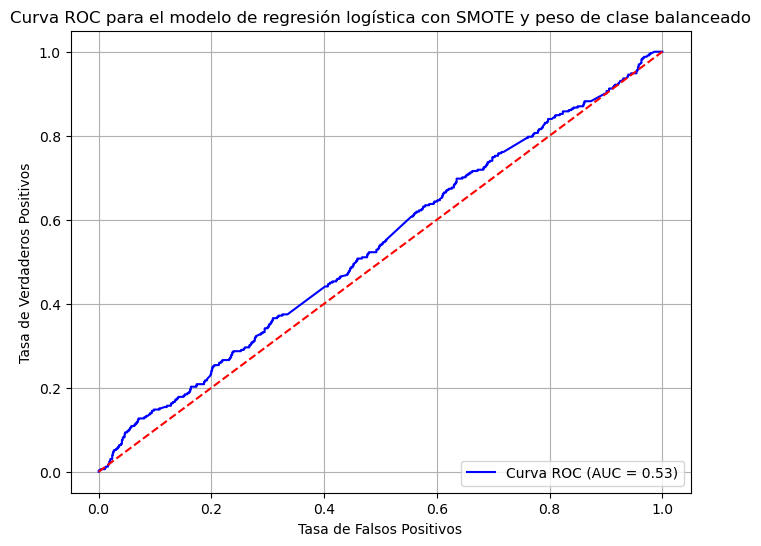

In [117]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el modelo de regresión logística con SMOTE y peso de clase balanceado')
plt.legend(loc='lower right')
plt.grid()
plt.show()

En la última instancia de prueba del modelo de regresión logística hay una mejora en la identificación de la clase positiva, aunque persisten problemas de underfitting. La matriz de confusión indica que se han predicho 154 instancias de la clase 1, con un recall del 47%, lo que sugiere que el modelo ha logrado captar una parte de las instancias positivas. 

Sin embargo, la precisión para la clase 1 es aún baja, con un valor de 0.12, lo que indica que el modelo sigue teniendo dificultades para clasificar correctamente los positivos. La exactitud general del 56% y el f1-score para la clase positiva de 0.19 reflejan que, a pesar del uso de técnicas para balancear los datos, el modelo no está logrando un rendimiento óptimo. 

#### 5.3.2 Modelo SVM

##### Fase 1

In [118]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target']  

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [119]:
# Crear el modelo SVM
model_svm = SVC(probability=True)  # probability=True para obtener las probabilidades para la curva ROC

# Ajustar el modelo
model_svm.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model_svm.predict(X_test)

# Predecir probabilidades para la curva ROC
y_pred_prob = model_svm.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print("Resultados del modelo SVM:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Resultados del modelo SVM:
Matriz de Confusión:
[[2669    0]
 [ 331    0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2669
           1       0.00      0.00      0.00       331

    accuracy                           0.89      3000
   macro avg       0.44      0.50      0.47      3000
weighted avg       0.79      0.89      0.84      3000



C:\Users\Adolfo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adolfo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adolfo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


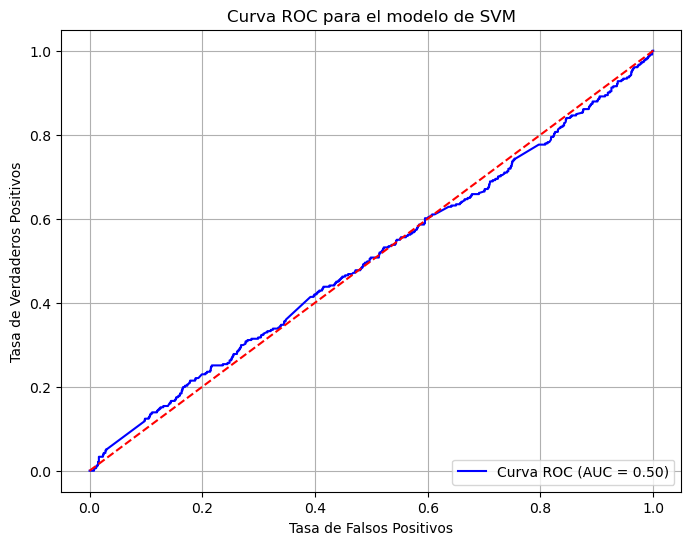

In [120]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el modelo de SVM')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Los resultados del modelo SVM muestran un desempeño similar al del modelo de regresión logística sin ajuste. La matriz de confusión indica que el modelo ha clasificado todas las instancias como pertenecientes a la clase 0, lo que resulta en un recall de 0% para la clase positiva.

La precisión de la clase 1 es cero, lo que implica que el modelo no ha sido capaz de identificar ninguna de las instancias positivas. La exactitud general del 89% puede ser engañosa, ya que se debe principalmente a la correcta clasificación de la clase 0, que es abrumadoramente más frecuente.

La no detección de verdaderos positivos sugiere un caso de underfitting, donde el modelo no está capturando la complejidad necesaria para distinguir entre las clases. 

La AUC de 0.50 sugiere que el modelo no tiene capacidad discriminativa y no está mejor que un modelo aleatorio.
Se aplicará ahora SMOTE con peso balanceado para observar si existe un ajuste en el modelo

##### Fase 2: SMOTE con peso de clase balanceado

In [122]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target'] 

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [123]:
# Crear el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE para balancear el conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#modelo SVM
model_svm = SVC(probability=True, class_weight='balanced')

# Ajustar el modelo
model_svm.fit(X_train_resampled, y_train_resampled)

# Predecir sobre el conjunto de prueba
y_pred = model_svm.predict(X_test)

# Predecir probabilidades para la curva ROC
y_pred_prob = model_svm.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print("Resultados del modelo SVM:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Resultados del modelo SVM:
Matriz de Confusión:
[[1291 1378]
 [ 146  185]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.48      0.63      2669
           1       0.12      0.56      0.20       331

    accuracy                           0.49      3000
   macro avg       0.51      0.52      0.41      3000
weighted avg       0.81      0.49      0.58      3000



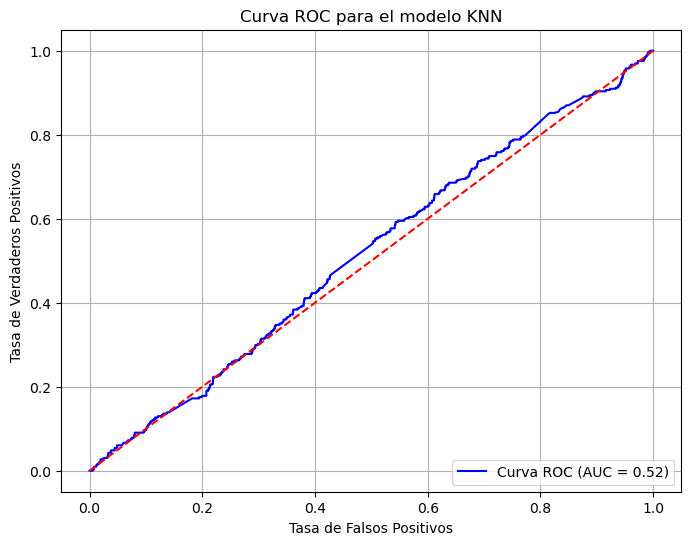

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el modelo KNN')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Los resultados del modelo SVM con balanceo y SMOTE reflejan una mejora en la identificación de la clase 1, con un recall del 56%. Sin embargo, la precisión sigue siendo baja, lo que indica que el modelo tiende a generar falsos positivos. 

La matriz de confusión muestra una distribución más equitativa entre las clases, pero la alta cantidad de falsos negativos sugiere que el modelo aún tiene dificultades para predecir la clase 1.

El modelo presenta un caso de underfitting, ya que, a pesar de los ajustes, la precisión general se mantiene en un 49%. 

#### 5.3.3 Modelo KNN

##### Fase 1

In [125]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [126]:
# Modelo KNN
model_knn = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar el número de vecinos según sea necesario

# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar n_neighbors según sea necesario

# Ajustar el modelo
model_knn.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model_knn.predict(X_test)

# Predecir probabilidades para la curva ROC
y_pred_prob = model_knn.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print("Resultados del modelo KNN:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Resultados del modelo KNN:
Matriz de Confusión:
[[2663    6]
 [ 331    0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2669
           1       0.00      0.00      0.00       331

    accuracy                           0.89      3000
   macro avg       0.44      0.50      0.47      3000
weighted avg       0.79      0.89      0.84      3000



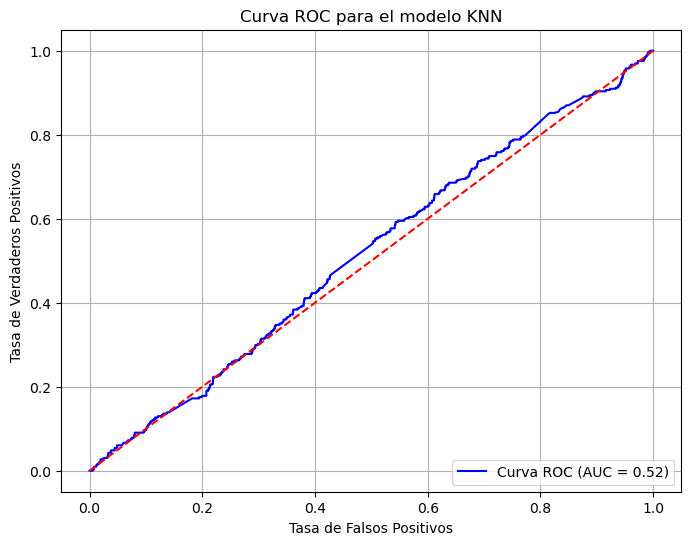

In [127]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el modelo KNN')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Los resultados del modelo KNN muestran un desempeño similar al de los modelos previos, con una precisión de 89%. Sin embargo, el modelo no ha logrado identificar ninguna instancia de la clase 1, como se evidencia en la matriz de confusión y el reporte de clasificación. El recall y el F1-score para la clase 1 son ambos cero, lo que indica que el modelo presenta un caso claro de underfitting, ya que no está capturando adecuadamente la clase minoritaria.

Se aplicarán técnicas de balanceo para ver si se presenta un mejor ajuste del modelo.

##### Fase 2: SMOTE con peso de clase balanceado

In [128]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [129]:
# SMOTE para equilibrar las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar n_neighbors según sea necesario

# Entrenar el modelo
knn_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = knn_model.predict(X_test)
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]  # Probabilidad para calcular la curva ROC

# Evaluar el modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Matriz de Confusión:
[[1685 1023]
 [ 640 2063]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67      2708
           1       0.67      0.76      0.71      2703

    accuracy                           0.69      5411
   macro avg       0.70      0.69      0.69      5411
weighted avg       0.70      0.69      0.69      5411



Área bajo la curva (AUC): 0.7684731008983399


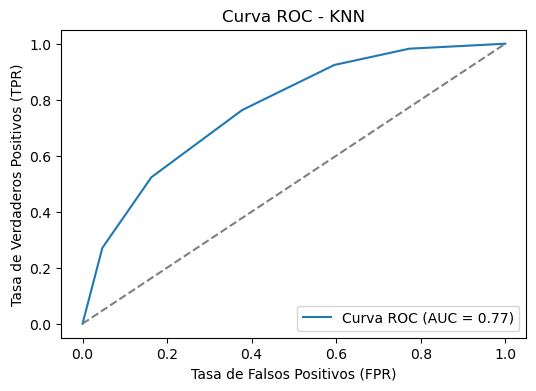

In [130]:
# Calcular ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Área bajo la curva (AUC): {roc_auc}")

# Graficar la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - KNN")
plt.legend(loc="lower right")
plt.show()

Los resultados del modelo KNN, tras aplicar técnicas de balanceo, muestran una mejora significativa en el rendimiento. La matriz de confusión revela que el modelo ha logrado identificar 2,063 instancias de la clase 1, lo que representa un avance notable en la detección de la clase minoritaria.

La precisión de la clase 0 es del 72% y para la clase 1 es del 67%, lo que indica un rendimiento relativamente equilibrado en ambas clases. El recall para la clase 1 ha aumentado al 76%, lo que sugiere que el modelo es efectivo en la identificación de casos positivos.

El F1-score también ha mejorado, alcanzando 0.71 para la clase 1, lo que indica un buen balance entre precisión y recall. En general, la precisión del modelo es del 69%, y la AUC de 0.77 sugiere que el modelo tiene un desempeño satisfactorio en la clasificación, superando el rendimiento aleatorio. Esto indica que el ajuste y balanceo han tenido un impacto positivo en la capacidad del modelo para distinguir entre las clases. 

El hecho de que la clase 1 tenga un recall del 76% sugiere que el modelo es capaz de identificar una proporción significativa de los casos positivos, lo que es positivo. Sin embargo, el ajuste podría acercase a un caso de posible overfitting.

#### 5.3.4 Modelo de clasificación por arboles de decisión

##### fase 1

In [131]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [132]:
# Crear el modelo de Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42)

# Crear el modelo de árbol de decisión
model_tree = DecisionTreeClassifier(random_state=42)

# Ajustar el modelo
model_tree.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model_tree.predict(X_test)

# Predecir probabilidades para la curva ROC
y_pred_prob = model_tree.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print("Resultados del modelo de Árbol de Decisión:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("Área bajo la curva (AUC):", roc_auc_score(y_test, y_pred_prob))

Resultados del modelo de Árbol de Decisión:
Matriz de Confusión:
[[2438  231]
 [ 303   28]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2669
           1       0.11      0.08      0.09       331

    accuracy                           0.82      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.80      0.82      0.81      3000

Área bajo la curva (AUC): 0.48854476653170176


Los resultados del modelo de Árbol de Decisión muestran un rendimiento variado en la clasificación de las clases. La matriz de confusión indica que el modelo identificó correctamente a 2,438 instancias de la clase 0, pero tuvo dificultades para detectar los casos de la clase 1, clasificando solo 28 de 331 correctamente.

La precisión para la clase 1 es de solo 0.11, lo que sugiere que el modelo presenta un alto número de falsos negativos, es decir, no está logrando identificar adecuadamente los casos positivos.

En cuanto al fitting, aunque el modelo parece ajustarse bien a la clase mayoritaria (0), es probable que esté sufriendo de underfitting en la clase minoritaria (1).

##### Fase 2: SMOTE con peso de clase balanceado

In [135]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [134]:
# Crear el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE para balancear el conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Crear y ajustar el modelo de árbol de decisión
model_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Ajustar el modelo
model_tree.fit(X_train_resampled, y_train_resampled)

# Predecir sobre el conjunto de prueba
y_pred = model_tree.predict(X_test)

# Evaluar el modelo
print("Resultados del modelo de Árbol de Decisión con SMOTE:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular AUC
y_pred_prob = model_tree.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nÁrea bajo la curva (AUC): {auc_score:.2f}")
plt.show()

Resultados del modelo de Árbol de Decisión con SMOTE:
Matriz de Confusión:
[[2017  652]
 [ 249   82]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      2669
           1       0.11      0.25      0.15       331

    accuracy                           0.70      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.80      0.70      0.74      3000


Área bajo la curva (AUC): 0.49


Los resultados del modelo de Árbol de Decisión con balanceo SMOTE y de clases muestran una mejora limitada. La matriz de confusión indica que se identificaron correctamente 2,017 instancias de la clase 0 y solo 82 de la clase 1, con una precisión de 0.11 para la clase minoritaria.

El recall para la clase 1 es de 0.25, lo que revela dificultades para capturar verdaderos positivos. La precisión general es del 70%, pero la f1-score para la clase 1 es muy baja (0.15), sugiriendo un desbalance significativo.

El AUC de 0.49 sugiere un rendimiento similar al azar, y el modelo presenta underfitting para la clase 1. Se recomienda ajustar la estructura del árbol o explorar otros modelos para mejorar la identificación de la clase minoritaria.

## 6. Evaluación

### 6.1 Revisión preliminar

| Modelo                  | Precisión | Recall | F1-Score | Exactitud | AUC   |
|------------------------|-----------|--------|----------|-----------|-------|
| Regresión Logística     | 0.00      | 0.00   | 0.00     | 0.89      | 0.54     |
| SVM sin balanceo       | 0.00      | 0.00   | 0.00     | 0.89      | 0.50  |
| SVM con SMOTE          | 0.12      | 0.56   | 0.20     | 0.49      | 0.49  |
| KNN sin balanceo       | 0.00      | 0.00   | 0.00     | 0.89      | 0.52  |
| KNN con SMOTE          | 0.67      | 0.76   | 0.71     | 0.69      | 0.77  |
| Árbol de Decisión      | 0.11      | 0.08   | 0.09     | 0.82      | 0.49  |
| Árbol de Decisión con SMOTE | 0.11      | 0.25   | 0.15     | 0.70      | 0.49  |

Los modelos aplicados en el análisis han mostrado variaciones en su desempeño. La regresión logística y SVM sin balanceo exhibieron problemas de underfitting, con una precisión de 0.89, pero incapacidad para identificar correctamente la clase 1, lo que se evidenció en AUCs de aproximadamente 0.50.

El modelo KNN, tras aplicar balanceo, logró una precisión de 0.69, con AUC de 0.77, mostrando mejor capacidad para clasificar ambas clases. En contraste, el Árbol de Decisión presentó dificultades significativas incluso con SMOTE, alcanzando solo un 70% de precisión y un AUC de 0.49, lo que sugiere underfitting. 

### 6.2 Elección de modelo

El modelo KNN mostró una mejora significativa en el rendimiento al manejar el desbalance de clases, logrando un AUC de 0.77. Esta métrica indica que el modelo tiene una mejor capacidad para discriminar entre las clases positivas y negativas. Además, el rendimiento del KNN en ambas clases fue relativamente equilibrado, lo que sugiere que puede generalizar mejor en comparación con otros modelos. Sin embargo, se debe tener en cuenta que el modelo KNN no aprende de los datos, sino que los guarda, junto con información adicional para que luego pueda decidir a qué clase pertenece el dato de test. También existe el problema de un posible sobreajuste.

Por otro lado, la regresión logística, con su interpretabilidad y robustez, permite obtener probabilidades de clase que son útiles en la toma de decisiones. Su naturaleza binaria la hace ideal para problemas de clasificación como el presente.

Para este caso, y asumiendo las necesidades del negocio con respecto a un modelo de clasificación que permita predicciones, se optará por el modelo de Regresión Logística Y KNN. Se aplicará una validación cruzada para ver que modelo resulta ser más óptimo, asumiendo la debilidad intrínseca de KNN frente la regresión logística.

### 6.3 Validación cruzada (Cross Validation)

In [136]:
# Features
features = [
    'EeccNac_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
    'Sexo'
] + list(dummies_region.columns)

# Variable objetivo
y = df['target']  # Reemplaza 'target_variable' con el nombre real de tu variable objetivo

# Separar las variables predictoras y la variable objetivo
X = df[features]  # Feature
y = df['target']    # Variable objetivo o target


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [137]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score

# KNN
knn_model = KNeighborsClassifier()

# validación cruzada
knn_cv_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')

# Resultados
print("KNN - Puntuaciones de Validación Cruzada:", knn_cv_scores)
print("KNN - Media de Puntuaciones:", knn_cv_scores.mean())

KNN - Puntuaciones de Validación Cruzada: [0.895  0.8985 0.8975 0.8975 0.8975]
KNN - Media de Puntuaciones: 0.8972


In [138]:
# modelo de regresión logística
model = LogisticRegression()

# validación cruzada con 5 pliegues
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Resultados
print("Puntuaciones de Validación Cruzada:", cv_scores)
print("Media de Puntuaciones:", np.mean(cv_scores))
print("Desviación Estándar de Puntuaciones:", np.std(cv_scores))

Puntuaciones de Validación Cruzada: [0.902  0.902  0.9015 0.9015 0.9015]
Media de Puntuaciones: 0.9017
Desviación Estándar de Puntuaciones: 0.0002449489742783452



Los resultados de la validación cruzada indican un rendimiento sólido de ambos modelos.

El modelo KNN muestra puntuaciones que varían entre 0.895 y 0.8985, con una media de 0.8972. Esto sugiere que KNN tiene un desempeño consistente, aunque no es el mejor en términos de precisión.

Por otro lado, la regresión logística supera a KNN con puntuaciones que oscilan entre 0.9015 y 0.902. La media de 0.9017 indica un rendimiento más robusto. Además, la desviación estándar de 0.00024 resalta la estabilidad del modelo, lo que es crucial en aplicaciones prácticas.

En conclusión, la regresión logística es preferible debido a su mayor precisión y confiabilidad en comparación con KNN, lo que la convierte en una opción más adecuada para este análisi

| Modelo                  | Puntuaciones CV          | Media CV | Desviación Estándar |
|------------------------|-------------------------|----------|---------------------|
| KNN                    | [0.895, 0.8985, 0.8975, 0.8975, 0.8975] | 0.8972   | -                   |
| Regresión Logística    | [0.902, 0.902, 0.9015, 0.9015, 0.9015]   | 0.9017   | 0.00024             |

### 6.4 Conclusiones de la evaluación

A lo largo de la actividad, se desarrolló un análisis exhaustivo de datos utilizando diversas técnicas de modelado predictivo, incluyendo regresión logística, KNN y árboles de decisión. Se realizó un proceso meticuloso de preparación de datos que incluyó la normalización de variables y el tratamiento de datos faltantes, lo que estableció una base sólida para el modelado.

Los resultados revelaron que, aunque la regresión logística y KNN mostraron un buen rendimiento en términos de precisión y área bajo la curva (AUC), la regresión logística con balanceo de clases presentó la mejor puntuación promedio en validación cruzada. En contraste, el árbol de decisión, aunque útil, no logró capturar eficazmente la clase minoritaria.

Finalmente, se concluyó que la regresión logística y KNN son las mejores opciones para este conjunto de datos, dadas sus capacidades para manejar variables tanto continuas como categóricas. Dentro de las dos, la regresión logística presenta un rendimiento superior en validación cruzada.